## Proyect 1 Understanding calibration in CNNs

Students
*Álex Sánchez Zurita*
*Jorge Barcenilla Gonzalez*
*Santiago Prieto Núñez*

In this lab, you will investigate the calibration convolutional CNNs in a classification setting:
- Read the paper "On calibration on modern neural networks," particularly sections 1 to 4
- Train a Lenet5 CNN from scratch to classify birds from cats in CIFAR10. Namely, we only consider two categories. Evaluate the reliability diagram and the ECE in the test set. You have methods for this in sklearn.
- Implement a basic temperature scaling (Platt's scaling), where the output probability p(zi) (being zi the logit) is modified by p(az_i), where a is a constant chosen to smooth the output probabilities. Study the effect of parameter 
a- Plot the reliability diagram and the ECE after applying the scaling.
(Optional, adds 0.25 additional points to the project grade) - Repeat the same experiment for a much bigger model obtained after fine-tuning a pre-trained model's last classification layer. Note that if you use a model pre-trained over a different database, you probably have to re-adapt the input dimensionality.
- Upload a zip file with a 3-page report with your main results and code for your experiments. The code can be a Python script or a Jupyter Notebook.
- You can work in groups of up to three. Each of you has to upload the solution to Aula Global!
- **Deadline is October 20, at 23:59**

## Analize the dataset


Number of images per class:
Train: {'bird': 5000, 'cat': 5000}
Test:  {'bird': 1000, 'cat': 1000}


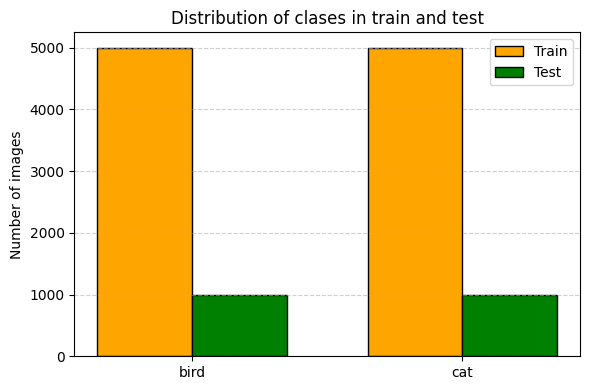

In [31]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Model and dataset variables
DATA_DIR = './data'
BATCH_SIZE = 32
NUM_EPOCH = 20
CV_PARAMS = False       # get the best params for train tools


# Transform the data to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 1-- Load the folders with the datsets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=transform)
classes = train_dataset.classes

# Count the imáges of each class
def count_images(dataset):
    counts = {cls: 0 for cls in classes}
    for _, label in dataset:
        counts[classes[label]] += 1
    return counts

train_counts = count_images(train_dataset)
test_counts = count_images(test_dataset)

print("\nNumber of images per class:")
print(f"Train: {train_counts}")
print(f"Test:  {test_counts}")

# 2-- Plot the clases proportions
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(classes))
width = 0.35

ax.bar(x - width/2, list(train_counts.values()), width, label='Train', color='orange', edgecolor='black')
ax.bar(x + width/2, list(test_counts.values()), width, label='Test', color='green', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of images')
ax.set_title('Distribution of clases in train and test')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

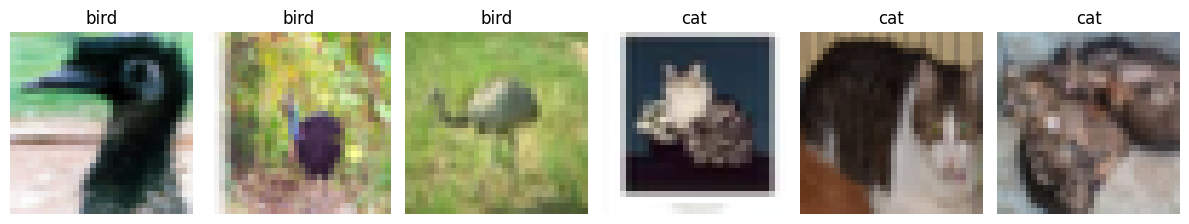

In [32]:
import random
from PIL import Image

# Show a sample of the images in the dataset
def show_images_from_dirs(base_dir, classes, n_images=4):
    img_paths = []
    labels = []

    # get the image paths
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        all_images = os.listdir(class_dir)

        # get a random sample of images
        selected_images = random.sample(all_images, min(int(n_images/len(classes)), len(all_images)))
        for img_name in selected_images:
            img_paths.append(os.path.join(class_dir, img_name))
            labels.append(cls)

    n_images = len(img_paths)
    plt.figure(figsize=(2 * n_images, 4))

    for i, path in enumerate(img_paths):
        img = Image.open(path)  # abrir imagen
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])

    plt.tight_layout()
    plt.show()

base_dir = './data/train'
classes = ['bird', 'cat']
show_images_from_dirs(base_dir, classes, n_images=6)

Finally we must change the classes from "bird" and "cat" to 0 and 1 to classify

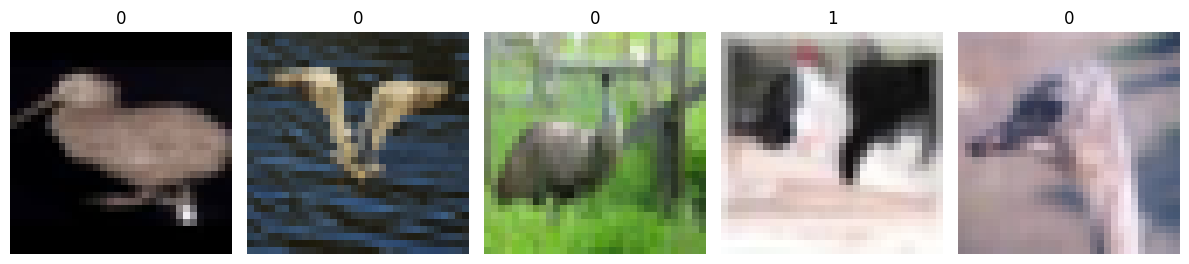

In [33]:
# filter dataset clases
train_dataset.targets = [0 if t==2 else 1 for t in train_dataset.targets]
test_dataset.targets = [0 if t==2 else 1 for t in test_dataset.targets]

# show 5 random images with its new class
indices = random.sample(range(len(train_dataset)), 5)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = img / 2 + 0.5  # convert orig from [-1,1] to [0,1]
    npimg = img.numpy()
    
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.title(label)  # show label

plt.tight_layout()
plt.show()


## Model definition

We can make the model following the original arquitecture of *Yann LeCun* in 
["GradientBased Learning Applied to Document Recognition"](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).
In the pag 7 we can follow a detailed descripiton of each layer component

In [34]:
import torch.nn as nn

# first we get the data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# class neded to replicate the subsampling of the original arquitecture
class Subsampling(nn.Module):
    """Subsampling entrenable como en LeNet-5 original"""
    def __init__(self, num_features):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(num_features,1,1))  # training coefficient
        self.bias = nn.Parameter(torch.zeros(num_features,1,1))  # bias

    def forward(self, x):
        # get the 2x2 blocks without overlap
        patches = x.unfold(2,2,2).unfold(3,2,2)
        # sum each element of the 4 blocks
        x = patches.sum(dim=-1).sum(dim=-1)
        # multuiply by the learned coefficient and sum the bias
        return torch.sigmoid(x * self.scale + self.bias)

# -- Create the Lenet5 by hand
class LeNet5_Original(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        # C1: Conv 5x5, 6 filters
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5)
        # S2: Subsampling layer with 6 maps
        self.s2 = Subsampling(6)
        # C3: Conv 5x5, 16 filtros (simplificado: conectado a todos)
        self.conv3 = nn.Conv2d(6,16, kernel_size=5)
        # S4: Subsampling entrenable
        self.s4 = Subsampling(16)
        # C5: Conv fully connected, 120 neuronas
        self.conv5 = nn.Conv2d(16, 120, kernel_size=5)
        # F6: fully connected, 84 neuronas
        self.fc6 = nn.Linear(120, 84)
        # Output
        self.fc7 = nn.Linear(84, num_classes)

    def forward(self, x):
        # C1 -> S2
        x = self.conv1(x)
        x = torch.relu(x)       # Originaly a Sigmoid activation of C1
        x = self.s2(x)
        # C3 -> S4
        x = self.conv3(x)
        x = torch.relu(x)       # Originaly a Sigmoid
        x = self.s4(x)
        # C5
        x = self.conv5(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)  # flatten for fully connected
        # F6 -> Output
        x = torch.relu(self.fc6(x))  # Originaly a Sigmoid for MLP f6
        x = self.fc7(x)
        return x

## Train model
Once defined the model we train it

In [35]:
import random
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import torch.optim as optim


def grid_optim(model, train_loader, params: dict, n_samples = 2000):
    """
    Get the best parameters for the model using CV_grid search.
    We use the train dataset
        model: neural network used
        train_loader: dataloader for train
        params: dictionary with the params of model
        device: 'cuda' or 'cpu'
        n_samples: number of images to do the grid search
    """

    # wrap of skorch to do the grid search of all model
    net = NeuralNetClassifier(
        model,
        max_epochs=5,                 # few epoch to optimize the cv
        lr=0.01,
        optimizer=optim.SGD,
        batch_size=64,
        criterion=nn.CrossEntropyLoss,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # get the data of dataloader
    X_train = torch.cat([x for x, _ in train_loader])
    y_train = torch.cat([y for _, y in train_loader])

    # get a subsample of the data
    idx = random.sample(range(len(test_dataset)), n_samples)
    X_sub = X_train[idx]
    y_sub = y_train[idx]

    # Do the gridsearch
    gs = GridSearchCV(
        estimator=net,
        param_grid=params,
        scoring='accuracy',
        cv=5,               # 3 folds
        refit=True,
        verbose=2
    ).fit(X_sub, y_sub)

    # Show the results and return the best optimizer
    print("✅ Best parameters:", gs.best_params_)
    print("🎯 Best optimizer accuracy:", gs.best_score_)
    best_optim = optim.SGD(model.parameters(),
                           lr=gs.best_params_["lr"],
                           momentum=gs.best_params_["optimizer__momentum"],
                           weight_decay=gs.best_params_["optimizer__weight_decay"])

    return best_optim


In [36]:
# First we need to define the enviroment of the train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📦 Using device:", device)

# Create a model of the LeNet5 arquitecture
model = LeNet5_Original(input_channels=3, num_classes=2).to(device) # upload to CPU

# define the loss and optimization funcitons
loss = nn.CrossEntropyLoss()

# get the best parámeters with a grid search
if CV_PARAMS:
    parameters = {
        'lr': np.logspace(-2,1,5),                          # best: 0.01
        'optimizer__momentum': np.linspace(0,1,4),          # best: 0.0
        'optimizer__weight_decay': np.linspace(0,1e-4,3)    # best: 0.0
    }
    optimizer = grid_optim(model, train_loader, parameters)
else:   # no search for hyperparámeters
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

📦 Using device: cuda


In [37]:
from sklearn.metrics import accuracy_score

# metrics and info of train
train_loss = []
train_acc = []
test_loss = 0
test_acc = 0

for epoch in range(NUM_EPOCH):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []
    
    for inputs, targets in train_loader:
        # Mover batch a GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Reset oprimizer
        optimizer.zero_grad()
        
        # 1º- Forward
        outputs = model(inputs)
        loss_val = loss(outputs, targets)
        
        # 2º Backward
        loss_val.backward()
        optimizer.step()    # optimizer step on backpropagation
        
        # 3º get accruacy and metrics
        epoch_loss += loss_val.item() * inputs.size(0)
        _, preds = outputs.max(1)                   # predictions
        total += targets.size(0)                    # number of elements in train
        correct += preds.eq(targets).sum().item()   # get number of correct preds
    
    train_loss.append(epoch_loss / total)                 # loss of the epoch
    train_acc.append(correct / total)
    print(f"Epoch {epoch+1}/{NUM_EPOCH} - Loss: {train_loss[epoch]:.4f} - Acc: {train_acc[epoch]:.4f}")

# get test value
correct = 0
total = 0

model.eval()  # model in evaluation mode
with torch.no_grad():  # no need of gradients
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # obtener la clase con máxima probabilidad
        
        # get loss values
        loss_val = loss(outputs, targets)
        test_loss += loss_val.item() * inputs.size(0)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_acc = correct / total
test_loss /= total

print(f"🚀 Test results:\nLoss:\t{test_loss}\nAccuracy:\t{test_acc}")

Epoch 1/20 - Loss: 0.6942 - Acc: 0.5005
Epoch 2/20 - Loss: 0.6792 - Acc: 0.5680
Epoch 3/20 - Loss: 0.6144 - Acc: 0.6650
Epoch 4/20 - Loss: 0.5718 - Acc: 0.7066
Epoch 5/20 - Loss: 0.5486 - Acc: 0.7302
Epoch 6/20 - Loss: 0.5259 - Acc: 0.7421
Epoch 7/20 - Loss: 0.5138 - Acc: 0.7490
Epoch 8/20 - Loss: 0.5028 - Acc: 0.7600
Epoch 9/20 - Loss: 0.4955 - Acc: 0.7628
Epoch 10/20 - Loss: 0.4895 - Acc: 0.7666
Epoch 11/20 - Loss: 0.4857 - Acc: 0.7734
Epoch 12/20 - Loss: 0.4838 - Acc: 0.7714
Epoch 13/20 - Loss: 0.4763 - Acc: 0.7778
Epoch 14/20 - Loss: 0.4761 - Acc: 0.7814
Epoch 15/20 - Loss: 0.4683 - Acc: 0.7827
Epoch 16/20 - Loss: 0.4662 - Acc: 0.7831
Epoch 17/20 - Loss: 0.4631 - Acc: 0.7835
Epoch 18/20 - Loss: 0.4627 - Acc: 0.7856
Epoch 19/20 - Loss: 0.4549 - Acc: 0.7900
Epoch 20/20 - Loss: 0.4474 - Acc: 0.7982
🚀 Test results:
Loss:	0.48545253682136535
Accuracy:	0.7715


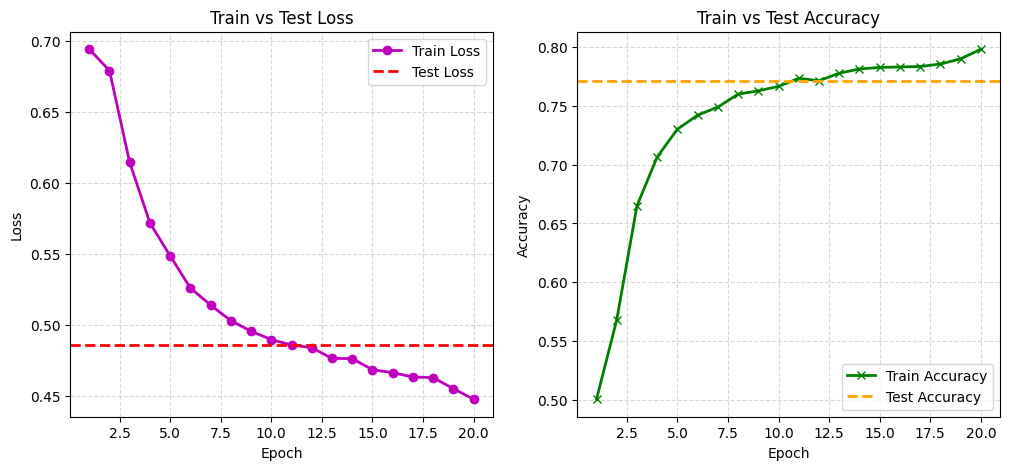

In [38]:
epochs = np.arange(1, NUM_EPOCH+1)

# --- Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'm-o', label='Train Loss', linewidth=2)
plt.axhline(y=test_loss, color='red', linestyle='--', linewidth=2, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'g-x', label='Train Accuracy', linewidth=2)
plt.axhline(y=test_acc, color='orange', linestyle='--', linewidth=2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()